# 7장 프로젝트 1: 영화 추천 시스템 만들기 - 예제 코드

fastFM 라이브러리에 구현된 인수분해 머신을 이용하는 추천 시스템의 예제 코드이다.

이 노트북을 실행하기 전에 `./download.sh` 스크립트를 먼저 실행하기 바란다.

## fastFM 라이브러리 동작 확인

더미 데이터로 fastFM이 동작하는지 여부를 확인한다. 여기서 사용자 ID와 상품 ID는 더미 변수이다.

In [10]:
!pip3 install fastFM

  Using cached https://files.pythonhosted.org/packages/41/31/7fb81ab6b11bd35f085eb9b4d0e2e48158056e4a639a1e67057519259512/fastFM-0.2.10.tar.gz
    ERROR: Complete output from command python setup.py egg_info:
    ERROR: Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/private/var/folders/wk/j74l4qss5nd_h7jdq9yrjl780000gn/T/pip-install-aqymfw3r/fastFM/setup.py", line 3, in <module>
        from Cython.Distutils import build_ext
    ModuleNotFoundError: No module named 'Cython'
    ----------------------------------------
ERROR: Command "python setup.py egg_info" failed with error code 1 in /private/var/folders/wk/j74l4qss5nd_h7jdq9yrjl780000gn/T/pip-install-aqymfw3r/fastFM/


In [5]:
%matplotlib inline
from sklearn.model_selection import learning_curve
import numpy as np
from fastFM import als

from sklearn.feature_extraction import DictVectorizer
import numpy as np
train = [
    {"user": "1", "item": "5", "age": 19},
    {"user": "2", "item": "43", "age": 33},
    {"user": "3", "item": "20", "age": 55},
    {"user": "4", "item": "10", "age": 20},
]
v = DictVectorizer()
X = v.fit_transform(train)
print(X.toarray())
y = np.array([5.0, 1.0, 2.0, 4.0])
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=2, l2_reg_w=0.1, l2_reg_V=0.5)
fm.fit(X, y)
fm.predict(v.transform({"user": "5", "item": "10", "age": 24}))

ModuleNotFoundError: No module named 'fastFM'

X.toarray() : one-hot encoding에서 sparse matrix임  
# category데이터는 X에 넣을 때만 one-hot encoding쓰고 y에 넣을 땐 label encoding

In [ ]:
# pandas로도 DictVectorizer과 똑같이 구현 가능

In [11]:
train = [
    {"user": "1", "item": "5", "age": 19},
    {"user": "2", "item": "43", "age": 33},
    {"user": "3", "item": "20", "age": 55},
    {"user": "4", "item": "10", "age": 20},
]

In [12]:
import pandas as pd

In [13]:
t = pd.DataFrame(train)

In [14]:
pd.concat([t,pd.get_dummies(t.item),pd.get_dummies(t.user)], axis=1).drop(['item','user'],axis=1)

,age,10,20,43,5,1,2,3,4
0,19,0,0,0,1,1,0,0,0
1,33,0,0,1,0,0,1,0,0
2,55,0,1,0,0,0,0,1,0
3,20,1,0,0,0,0,0,0,1


## 무비렌즈 데이터 분석하기

MovieLens 데이터의 경향을 탐색해본다.

In [4]:
import pandas as pd

# 사용자 정보 읽어들이기
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols)
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [5]:
# 레이팅 정보 읽어들이기
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols)
ratings['date'] = pd.to_datetime(ratings['unix_timestamp'],unit='s')
ratings.head()

,user_id,movie_id,rating,unix_timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22
2,22,377,1,878887116,1997-11-07 07:18:36
3,244,51,2,880606923,1997-11-27 05:02:03
4,166,346,1,886397596,1998-02-02 05:33:16


In [10]:
# 영화 정보 읽어들이기
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5), encoding = "latin1")
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [11]:
# 사용자-영화-평점 3가지 정보를 한 데이터프레임으로 합치기
movie_rating = pd.merge(movies, ratings)
lens = pd.merge(movie_rating, users)
lens.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,date,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,1998-02-17 18:20:08,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,1998-02-17 18:07:27,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,1998-02-17 17:31:36,60,M,retired,95076


In [12]:
# 가장 평점을 많이 받은 25개 작품
lens.title.value_counts()[:25]

Star Wars (1977)                             583
Contact (1997)                               509
Fargo (1996)                                 508
Return of the Jedi (1983)                    507
Liar Liar (1997)                             485
English Patient, The (1996)                  481
Scream (1996)                                478
Toy Story (1995)                             452
Air Force One (1997)                         431
Independence Day (ID4) (1996)                429
Raiders of the Lost Ark (1981)               420
Godfather, The (1972)                        413
Pulp Fiction (1994)                          394
Twelve Monkeys (1995)                        392
Silence of the Lambs, The (1991)             390
Jerry Maguire (1996)                         384
Chasing Amy (1997)                           379
Rock, The (1996)                             378
Empire Strikes Back, The (1980)              367
Star Trek: First Contact (1996)              365
Back to the Future (

In [ ]:
# 저번 수업에서 평점을 몇 개 받았는지도 사실 고려했어야 했다.
# pandas로 데이터 이해했어야 했다.

In [13]:
# 평점 수와 평균 평점을 집계한 다음 평균 평점 순으로 정렬
movie_stats = lens.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.sort_values(by=[('rating', 'mean')], ascending=False).head()

rating     
                                             size mean
title                                                 
They Made Me a Criminal (1939)                  1  5.0
Marlene Dietrich: Shadow and Light (1996)       1  5.0
Saint of Fort Washington, The (1993)            2  5.0
Someone Else's America (1995)                   1  5.0
Star Kid (1997)                                 3  5.0

In [14]:
# 평점 수가 100건 이상인 영화만으로 범위를 좁혀 평점 수 상위 15작품 확인
atleast_100 = movie_stats['rating']['size'] >=100  # 불확실성을 제거하기 위해서 데이터 처리
movie_stats[atleast_100].sort_values(by=[('rating', 'mean')], ascending=False)[:15]

rating          
                                         size      mean
title                                                  
Close Shave, A (1995)                     112  4.491071
Schindler's List (1993)                   298  4.466443
Wrong Trousers, The (1993)                118  4.466102
Casablanca (1942)                         243  4.456790
Shawshank Redemption, The (1994)          283  4.445230
Rear Window (1954)                        209  4.387560
Usual Suspects, The (1995)                267  4.385768
Star Wars (1977)                          583  4.358491
12 Angry Men (1957)                       125  4.344000
Citizen Kane (1941)                       198  4.292929
To Kill a Mockingbird (1962)              219  4.292237
One Flew Over the Cuckoo's Nest (1975)    264  4.291667
Silence of the Lambs, The (1991)          390  4.289744
North by Northwest (1959)                 179  4.284916
Godfather, The (1972)                     413  4.283293

Text(0,0.5,'(사용자별) 평가 횟수')

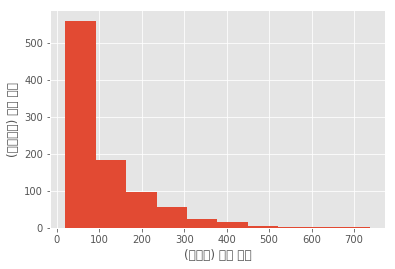

In [17]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

# user_id 별 평가 횟수의 히스토그램
lens.groupby('user_id').size().sort_values(ascending=False).hist()

plt.xlabel('(영화별) 평점 개수')
plt.ylabel('(사용자별) 평가 횟수')

In [18]:
# 사용자별 평가 횟수와 평점 평균
user_stats = lens.groupby('user_id').agg({'rating': [np.size, np.mean]})
user_stats['rating'].describe()

,size,mean
count,943.000000,943.000000
mean,106.044539,3.588191
std,100.931743,0.445233
min,20.000000,1.491954
25%,33.000000,3.323054
50%,65.000000,3.620690
75%,148.000000,3.869565
max,737.000000,4.869565


## MovieLens 데이터로 예측 모델 만들기

지금부터는 fastFM 라이브러리를 이용한 예측 모델을 만들어 본다. 인수분해 머신을 이용한 예측 모델을 만들고, 인수분해 머신의 특징대로 특징값을 자유롭게 추가할 수 있는지도 확인해 볼 것이다.

### 데이터 읽기

데이터를 개발 데이터(학습 데이터 + 검증 데이터)와 테스트 데이터로 분할한다. 그리고 사용자 ID, 영화 ID 필드를 더미변수로 만든다.

In [19]:
# 데이터 읽기
def loadData(filename, path="ml-100k/"):
    data = []
    y = []
    users=set()
    items=set()
    with open(path+filename) as f:
        for line in f:
            (user, movieid, rating, ts)=line.split('\t')
            data.append({ "user_id": str(user), "movie_id": str(movieid)})
            y.append(float(rating))
            users.add(user)
            items.add(movieid)

    return (data, np.array(y), users, items)


In [20]:
(dev_data, y_dev, dev_users, dev_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

In [21]:
from sklearn.model_selection import train_test_split

v = DictVectorizer()
X_dev = v.fit_transform(dev_data)
X_test = v.transform(test_data)
np.std(y_test)
X_train, X_dev_test, y_train, y_dev_test = train_test_split(X_dev, y_dev, test_size=0.1, random_state=42)

### 반복 횟수에 따른 영향

개발 데이터를 사용하여 반복 횟수에 따라 RMSE가 어떻게 바뀌는지 알아보자.

0.895969274557


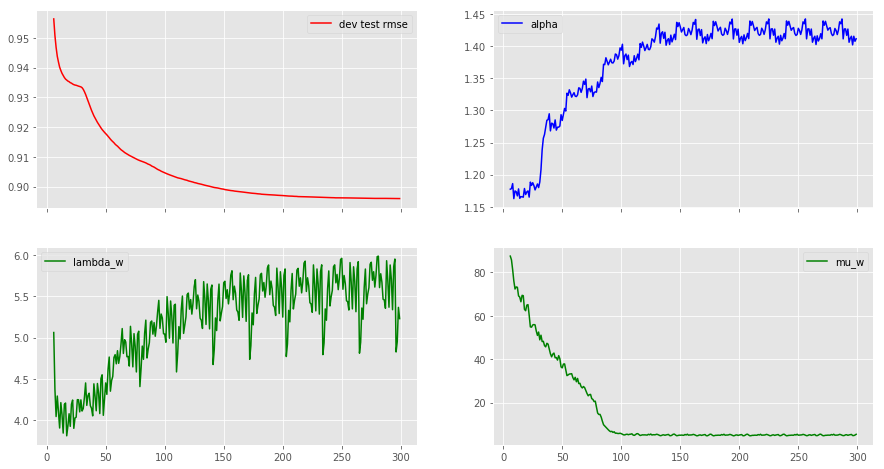

In [22]:
from sklearn.metrics import mean_squared_error
from fastFM import mcmc

n_iter = 300
step_size = 1
seed = 123
rank = 4


fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)
# 모델 및 하이퍼파리미터 초기화
# 불확실성이 크기 때문에 parameter를 정하는 결정권자가 있어야 한다.
fm.fit_predict(X_train, y_train, X_dev_test)

rmse_dev_test = []
rmse_test = []
hyper_param = np.zeros((n_iter -1, 3 + 2 * rank), dtype=np.float64)

for nr, i in enumerate(range(1, n_iter)):
    fm.random_state = i * seed
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test, n_more_iter=step_size)
    rmse_test.append(np.sqrt(mean_squared_error(y_pred, y_dev_test)))
    hyper_param[nr, :] = fm.hyper_param_

values = np.arange(1, n_iter)
x = values * step_size
burn_in = 5
x = x[burn_in:]

from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

axes[0, 0].plot(x, rmse_test[burn_in:], label='dev test rmse', color="r")
axes[0, 0].legend()
axes[0, 1].plot(x, hyper_param[burn_in:,0], label='alpha', color="b")
axes[0, 1].legend()
axes[1, 0].plot(x, hyper_param[burn_in:,1], label='lambda_w', color="g")
axes[1, 0].legend()
axes[1, 1].plot(x, hyper_param[burn_in:,3], label='mu_w', color="g")
axes[1, 1].legend()

print(np.min(rmse_test))

In [15]:
n_iter = 100
rank = 4
seed = 333
step_size = 1

fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)
# 계수 초기화
fm.fit_predict(X_train, y_train, X_dev_test)

rmse_test = []
rmse_new = []
hyper_param = np.zeros((n_iter -1, 3 + 2 * rank), dtype=np.float64)
for nr, i in enumerate(range(1, n_iter)):
    fm.random_state = i * seed
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test, n_more_iter=step_size)
    rmse_test.append(np.sqrt(mean_squared_error(y_pred, y_dev_test)))
    hyper_param[nr, :] = fm.hyper_param_

------- restart ----------
iter:10 rmse:0.941
iter:20 rmse:0.935
iter:30 rmse:0.934
iter:40 rmse:0.932
iter:50 rmse:0.923
iter:60 rmse:0.917
iter:70 rmse:0.913
iter:80 rmse:0.909
iter:90 rmse:0.906


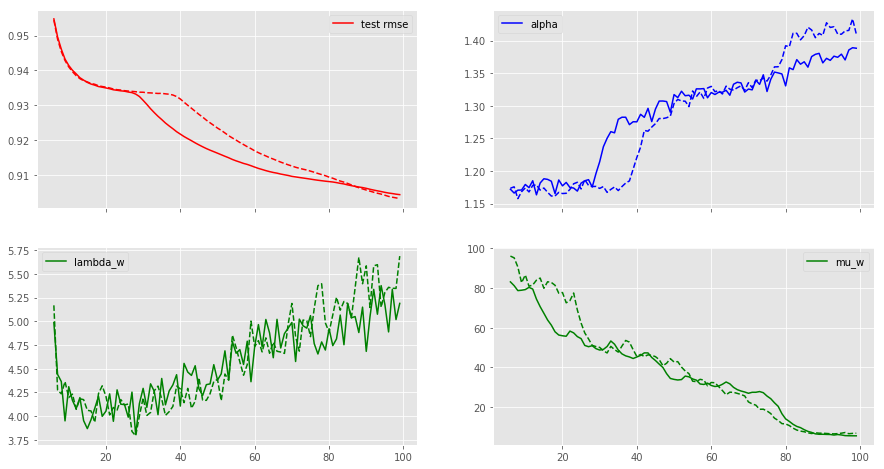

min rmse: 0.903


In [16]:
print('------- restart ----------')
values = np.arange(1, n_iter)
rmse_test_re = []
hyper_param_re = np.zeros((len(values), 3 + 2 * rank), dtype=np.float64)
for nr, i in enumerate(values):
    fm = mcmc.FMRegression(n_iter=i, rank=rank, random_state=seed)
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_dev_test))
    rmse_test_re.append(rmse)
    hyper_param_re[nr, :] = fm.hyper_param_
    if i % 10 == 0:
        print('iter:{} rmse:{:.3f}'.format(i, rmse))

from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

x = values * step_size
burn_in = 5
x = x[burn_in:]

#with plt.style.context('ggplot'):
axes[0, 0].plot(x, rmse_test[burn_in:], label='test rmse', color="r")
axes[0, 0].plot(values[burn_in:], rmse_test_re[burn_in:], ls="--", color="r")
axes[0, 0].legend()

axes[0, 1].plot(x, hyper_param[burn_in:,0], label='alpha', color="b")
axes[0, 1].plot(values[burn_in:], hyper_param_re[burn_in:,0], ls="--", color="b")
axes[0, 1].legend()

axes[1, 0].plot(x, hyper_param[burn_in:,1], label='lambda_w', color="g")
axes[1, 0].plot(values[burn_in:], hyper_param_re[burn_in:,1], ls="--", color="g")
axes[1, 0].legend()

axes[1, 1].plot(x, hyper_param[burn_in:,3], label='mu_w', color="g")
axes[1, 1].plot(values[burn_in:], hyper_param_re[burn_in:,3], ls="--", color="g")
axes[1, 1].legend()

plt.show()
print("min rmse: {:.3f}".format(np.min(rmse_test_re)))

### Rank가 미치는 영향

상호작용의 rank가 RMSE에 미치는 영향을 알아보자.

rank:4	rmse:0.903
rank:8	rmse:0.898
rank:16	rmse:0.896
rank:32	rmse:0.893
rank:64	rmse:0.893
min rmse: 0.893


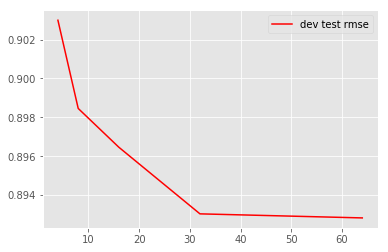

In [23]:
n_iter = 100
seed = 333

rmse_test = []

ranks = [4, 8, 16, 32, 64]


for rank in ranks:
    fm = mcmc.FMRegression(n_iter=n_iter, rank=rank, random_state=seed)
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_dev_test))
    rmse_test.append(rmse)
    print('rank:{}\trmse:{:.3f}'.format(rank, rmse))

plt.plot(ranks, rmse_test, label='dev test rmse', color="r")
plt.legend()

print("min rmse: {:.3f}".format(np.min(rmse_test)))

In [ ]:
fm = mcmc.FMRegression(n_iter=300, rank=32, random_state=seed)
fm.fit_predict(X_train, y_train, X_test)
y_pred = fm.fit_predict(X_train, y_train, X_test)
np.sqrt(mean_squared_error(y_pred, y_test))

### 평점 표준화가 미치는 영향

평점 값을 표준화했을때 어떤 영향이 있는지 알아보자.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
y_train_norm = scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
fm = mcmc.FMRegression(n_iter=300, rank=32, random_state=seed)
y_pred = fm.fit_predict(X_train, y_train_norm, X_test)
np.sqrt(mean_squared_error(scaler.inverse_transform(y_pred), y_test))

In [ ]:
n_iter = 200
step_size = 1
seed = 123
rank = 32

fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)
# 모델 및 하이퍼 파라미터 초기화
fm.fit_predict(X_train, y_train_norm, X_test)

rmse_test = []
rmse_new = []
hyper_param = np.zeros((n_iter -1, 3 + 2 * rank), dtype=np.float64)
for nr, i in enumerate(range(1, n_iter)):
    fm.random_state = i * seed
    y_pred = fm.fit_predict(X_train, y_train_norm, X_test, n_more_iter=step_size)
    rmse_test.append(np.sqrt(mean_squared_error(scaler.inverse_transform(y_pred), y_test)))
    hyper_param[nr, :] = fm.hyper_param_

values = np.arange(1, n_iter)
x = values * step_size
burn_in = 5
x = x[burn_in:]

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

axes[0, 0].plot(x, rmse_test[burn_in:], label='test rmse', color="r")
axes[0, 0].legend()
axes[0, 1].plot(x, hyper_param[burn_in:,0], label='alpha', color="b")
axes[0, 1].legend()
axes[1, 0].plot(x, hyper_param[burn_in:,1], label='lambda_w', color="g")
axes[1, 0].legend()
axes[1, 1].plot(x, hyper_param[burn_in:,3], label='mu_w', color="g")
axes[1, 1].legend()

print("min rmse: {:.3f}, argmin: {}".format(np.min(rmse_test), x[np.argmin(rmse_test)]))

### 특징값의 조합에 따른 영향

특징값을 다르게 조합해가며 어떤 효과가 있는지 확인해 본다.

In [21]:
lens['user_id'] = lens['user_id'].astype(str)
lens['movie_id'] = lens['movie_id'].astype(str)
lens['year'] = lens['date'].apply(str).str.split('-').str.get(0)
lens['release_year'] = lens['release_date'].apply(str).str.split('-').str.get(2)
lens['year'] = lens['date'].apply(str).str.split('-').str.get(0)
lens['release_year'] = lens['release_date'].apply(str).str.split('-').str.get(2)

candidate_columns = [
    ['user_id','movie_id', 'release_year', 'age', 'sex', 'year',  'rating'],
    ['user_id','movie_id', 'age', 'sex', 'year',  'rating'],
    ['user_id','movie_id', 'sex', 'year',  'rating'],
    ['user_id','movie_id', 'age', 'sex', 'rating'],    
    ['user_id','movie_id', 'rating'],    
]

rmse_test = []

n_iter = 500
seed = 123
rank = 8


for column in candidate_columns:
    filtered_lens = lens[column].dropna()
    v = DictVectorizer()
    X_more_feature = v.fit_transform(list(filtered_lens.drop('rating', axis=1).T.to_dict().values()))
    y_more_feature = filtered_lens['rating'].tolist()

    X_mf_train, X_mf_test, y_mf_train, y_mf_test = train_test_split(X_more_feature, y_more_feature, test_size=0.1, random_state=42)

    scaler = StandardScaler()
    y_mf_train_norm = scaler.fit_transform(np.array(y_mf_train).reshape(-1, 1)).ravel()

    fm = mcmc.FMRegression(n_iter=n_iter, rank=rank, random_state=seed)
    # 모델 및 하이퍼 파라미터 초기화
    fm.fit_predict(X_mf_train, y_mf_train_norm, X_mf_test)

    y_pred = fm.fit_predict(X_mf_train, y_mf_train_norm, X_mf_test)
    rmse_test.append(np.sqrt(mean_squared_error(scaler.inverse_transform(y_pred.reshape(-1, 1)), y_mf_test)))

print(rmse_test)

/Users/ariga/work/ml-at-work/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[0.89663489349975933, 0.89436482176488863, 0.88504517374829361, 0.89223758528114061, 0.88774455742842695]


(0.88, 0.94)

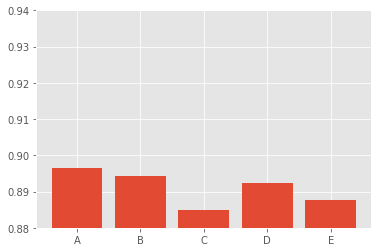

In [22]:
ind = np.arange(len(rmse_test))
bar = plt.bar(ind, height=rmse_test)
plt.xticks(ind, ('A', 'B', 'C', 'D', 'E'))
plt.ylim((0.88, 0.94))
